**SOLUCIÓN COMPARATIVA CONFORME VS BONFERRONI con dataset grande: daily-min-temperatures.csv**

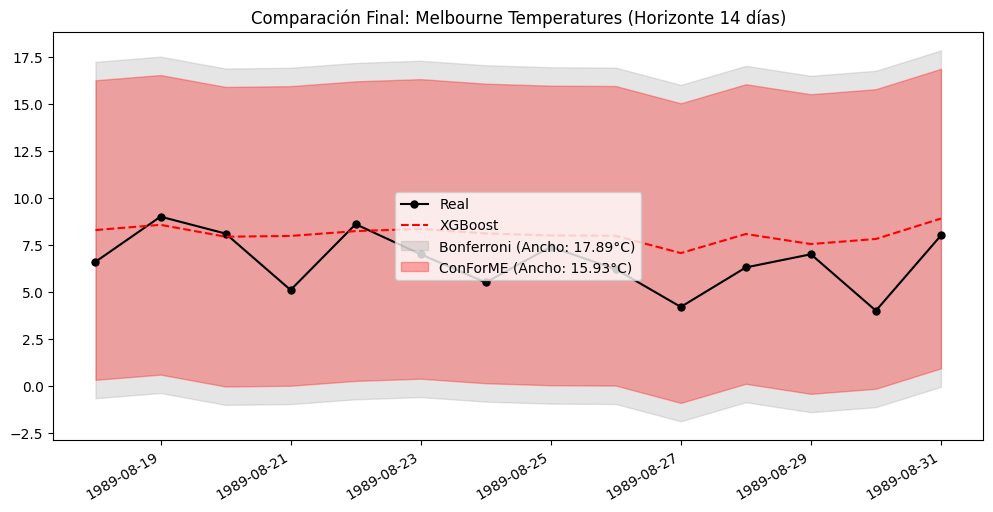


--- COMPARATIVA CON DATASET GRANDE ---
            Métrica Bonferroni (Tradicional) ConForME (Paper)
 Cobertura Conjunta                    96.8%            90.7%
Ancho del Intervalo                  17.89°C          15.93°C


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# =========================================================
# CONFIGURACIÓN (Con más datos, podemos ser más exigentes)
# =========================================================
FILE_NAME = 'daily-min-temperatures.csv'
ALPHA = 0.1     # 90% de confianza
H = 14          # ¡Probemos ahora con 14 días (2 semanas)!
WIN = 60        # Usemos 2 meses de historia

# ---------------------------------------------------------
# MÓDULO 1: PREPROCESAMIENTO ADAPTADO
# ---------------------------------------------------------
def prepare_temp_data(file_path, input_window, horizon):
    # Nota: A veces este CSV tiene comillas o errores, los limpiamos
    df = pd.read_csv(file_path)
    df.columns = [c.replace('"', '').strip() for c in df.columns] # Limpiar nombres
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # Aseguramos que la temperatura sea numérica
    df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
    df = df.dropna()

    data = df['Temp'].values
    dates = df['Date'].values

    X, y, target_dates = [], [], []
    for i in range(len(data) - input_window - horizon):
        X.append(data[i : i + input_window])
        y.append(data[i + input_window : i + input_window + horizon])
        target_dates.append(dates[i + input_window : i + input_window + horizon])

    return np.array(X), np.array(y), np.array(target_dates)

# ---------------------------------------------------------
# MÓDULO 2 Y 3: MODELO Y UMBRALES
# ---------------------------------------------------------
def get_thresholds(y_calib, y_pred_calib, alpha):
    errors = np.abs(y_calib - y_pred_calib)
    n = len(errors)
    horiz = y_calib.shape[1]

    # ConForME (Joint)
    joint_scores = np.max(errors, axis=1)
    q_level_conf = np.ceil((n + 1) * (1 - alpha)) / n
    q_hat_conf = np.quantile(joint_scores, min(q_level_conf, 1.0))

    # Bonferroni (Conservador)
    alpha_bonf = alpha / horiz
    q_level_bonf = np.ceil((n + 1) * (1 - alpha_bonf)) / n
    q_hat_bonf = np.quantile(errors.flatten(), min(q_level_bonf, 1.0))

    return q_hat_conf, q_hat_bonf

# ---------------------------------------------------------
# MÓDULO 4: EJECUCIÓN
# ---------------------------------------------------------
X, y, dates = prepare_temp_data(FILE_NAME, WIN, H)

# Con 3000+ datos, el split ahora sí es robusto
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_cal, X_test, y_cal, y_test, dates_cal, dates_test = train_test_split(
    X_temp, y_temp, dates[len(X_train):], test_size=0.5, shuffle=False
)

model = xgb.XGBRegressor(objective='reg:absoluteerror', n_estimators=200, learning_rate=0.05)
model.fit(X_train, y_train)

y_pred_cal = model.predict(X_cal)
q_hat_conf, q_hat_bonf = get_thresholds(y_cal, y_pred_cal, ALPHA)
y_pred_test = model.predict(X_test)

# ---------------------------------------------------------
# MÓDULO 5: VISUALIZACIÓN (Muestra aleatoria del test)
# ---------------------------------------------------------
idx = 50 # Con más datos, podemos ver una muestra intermedia
plt.figure(figsize=(12, 6))
plt.plot(dates_test[idx], y_test[idx], 'k-o', label="Real", markersize=5)
plt.plot(dates_test[idx], y_pred_test[idx], 'r--', label="XGBoost")

plt.fill_between(dates_test[idx], y_pred_test[idx] - q_hat_bonf, y_pred_test[idx] + q_hat_bonf,
                 color='gray', alpha=0.2, label=f"Bonferroni (Ancho: {q_hat_bonf*2:.2f}°C)")
plt.fill_between(dates_test[idx], y_pred_test[idx] - q_hat_conf, y_pred_test[idx] + q_hat_conf,
                 color='red', alpha=0.3, label=f"ConForME (Ancho: {q_hat_conf*2:.2f}°C)")

plt.title(f"Comparación Final: Melbourne Temperatures (Horizonte {H} días)")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# ---------------------------------------------------------
# MÓDULO 6: TABLA COMPARATIVA
# ---------------------------------------------------------
def get_metrics(y_true, y_pred, q_val):
    max_errs = np.max(np.abs(y_true - y_pred), axis=1)
    coverage = np.mean(max_errs <= q_val) * 100
    return f"{coverage:.1f}%", f"{q_val * 2:.2f}°C"

cov_c, width_c = get_metrics(y_test, y_pred_test, q_hat_conf)
cov_b, width_b = get_metrics(y_test, y_pred_test, q_hat_bonf)

print("\n--- COMPARATIVA CON DATASET GRANDE ---")
print(pd.DataFrame({
    "Métrica": ["Cobertura Conjunta", "Ancho del Intervalo"],
    "Bonferroni (Tradicional)": [cov_b, width_b],
    "ConForME (Paper)": [cov_c, width_c]
}).to_string(index=False))